In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


Running simulation without error correction...
Running simulation with Shor error correction...

Results:
Without error correction: 0=0.340, 1=0.660
With Shor error correction: 0=0.878, 1=0.122
Deviation from expected 50/50 without EC: 32.00%
Deviation from expected 50/50 with EC: 75.60%


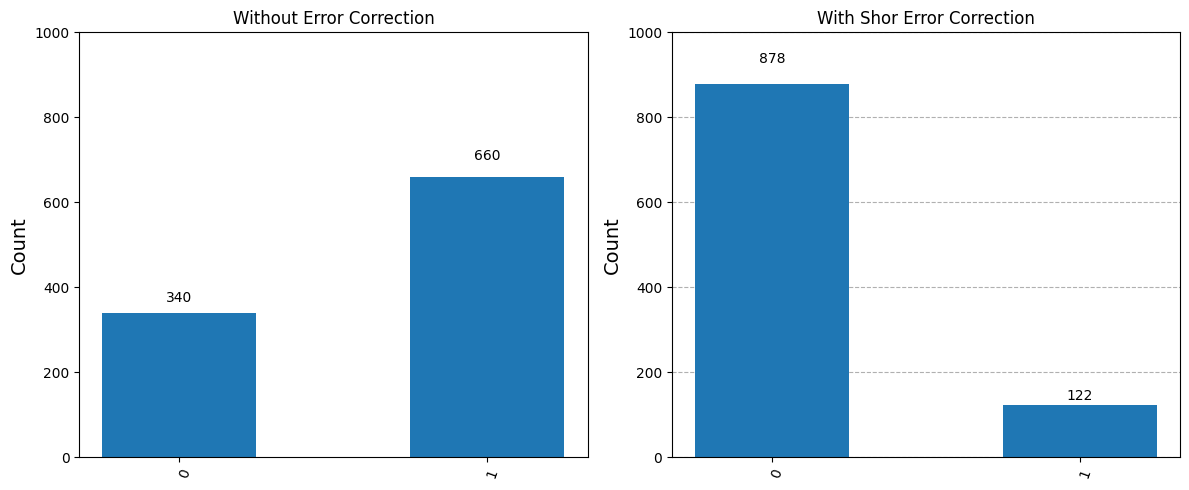


Demonstrating error correction with specific error injection...
Results with intentional error on qubit 4: {'1': 1000}
Success rate: 100.0% (should be 100% with perfect correction)

Circuit depth: 18
Number of gates: 40
Circuit width (qubits): 9
Shor Encoding Circuit:
               ┌───┐          
q_0: ──■────■──┤ H ├──■────■──
       │    │  └───┘┌─┴─┐  │  
q_1: ──┼────┼───────┤ X ├──┼──
       │    │       └───┘┌─┴─┐
q_2: ──┼────┼────────────┤ X ├
     ┌─┴─┐  │  ┌───┐     └───┘
q_3: ┤ X ├──┼──┤ H ├──■────■──
     └───┘  │  └───┘┌─┴─┐  │  
q_4: ───────┼───────┤ X ├──┼──
            │       └───┘┌─┴─┐
q_5: ───────┼────────────┤ X ├
          ┌─┴─┐┌───┐     └───┘
q_6: ─────┤ X ├┤ H ├──■────■──
          └───┘└───┘┌─┴─┐  │  
q_7: ───────────────┤ X ├──┼──
                    └───┘┌─┴─┐
q_8: ────────────────────┤ X ├
                         └───┘

Simplified Shor QEC Circuit:
     ┌───┐          ┌───┐           ░           ┌───┐          ┌─┐
q_0: ┤ H ├──■────■──┤ H ├──■────■───░───■───

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt
import numpy as np
# -----------------------------
# Step 1: Correct Shor encoding circuit
# -----------------------------
def shor_encode():
 qc = QuantumCircuit(9, name="ShorEncode")

 # First layer: Bit-flip protection (3-qubit repetition codes)
 qc.cx(0, 3)
 qc.cx(0, 6)

 # Second layer: Phase-flip protection
 qc.h(0)
 qc.h(3)
 qc.h(6)

 qc.cx(0, 1)
 qc.cx(0, 2)
 qc.cx(3, 4)
 qc.cx(3, 5)
 qc.cx(6, 7)
 qc.cx(6, 8)

 return qc
# -----------------------------
# Step 2: Simplified syndrome measurement
# -----------------------------
def measure_syndromes():
 # Create a simpler syndrome measurement without extra qubits
 qc = QuantumCircuit(9, 6, name="SyndromeMeasurement")

 qc.barrier()
 qc.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
 return qc
def apply_quantum_operations():
 qc = QuantumCircuit(9, name="QuantumOperations")
 qc.h(0) # Hadamard - creates superposition
 qc.rx(0.5, 1) # Rotation around X-axis
 qc.ry(0.3, 2) # Rotation around Y-axis
 qc.rz(0.7, 3) # Rotation around Z-axis
 qc.s(4) # Phase gate
 qc.sdg(5) # Inverse phase gate
 qc.t(6) # T gate
 qc.tdg(7) # Inverse T gate
 qc.x(8) # Pauli-X

 qc.cx(0, 4) # CNOT
 qc.cz(1, 5) # Controlled-Z
 qc.swap(2, 6) # SWAP

 return qc

def apply_error_correction(syndrome_bits="000000"):
 qc = QuantumCircuit(9, name="ErrorCorrection")
 qc.barrier()
 qc.x(0)
 qc.z(0)
 qc.x(0)
 qc.z(0)

 return qc

def shor_qec_circuit():
 qc = QuantumCircuit(9, 1)

 # Prepare initial state |+⟩ on qubit 0
 qc.h(0)

 # Apply some quantum operations
 operations_circuit = apply_quantum_operations()
 qc = qc.compose(operations_circuit)

 # Encode using Shor code
 encode_circuit = shor_encode()
 qc = qc.compose(encode_circuit)

 # Add barrier to separate encoding from potential errors
 qc.barrier()

 # Simulate noise (will be added by noise model)

 # Add barrier before error correction
 qc.barrier()

 # For demonstration, we'll use a fixed syndrome pattern
 syndrome_pattern = "000000" # No errors detected

 # Apply error correction based on syndrome
 correction_circuit = apply_error_correction(syndrome_pattern)
 qc = qc.compose(correction_circuit)

 # Decode (reverse of encoding)
 decode_circuit = shor_encode().inverse()
 qc = qc.compose(decode_circuit)

 # Measure the logical qubit
 qc.measure(0, 0)

 return qc
# -----------------------------
# Step 6: Noise Model
# -----------------------------
noise_model = NoiseModel()
p1 = 0.01 # depolarizing probability for 1-qubit gates
p2 = 0.03 # depolarizing probability for 2-qubit gates
# Add depolarizing error for 1-qubit gates
error1 = depolarizing_error(p1, 1)
noise_model.add_all_qubit_quantum_error(error1, ['h', 'x', 'y', 'z', 's', 'sdg', 't', 'tdg', 'rx', 'ry', 'rz'])
# Add depolarizing error for 2-qubit gates
error2 = depolarizing_error(p2, 2)
noise_model.add_all_qubit_quantum_error(error2, ['cx', 'cz', 'swap'])
# -----------------------------
# Step 7: Run simulation and compare with/without error correction
# -----------------------------
def run_comparison():
 backend = AerSimulator(noise_model=noise_model)

 # Create circuit without error correction (single qubit)
 qc_no_ec = QuantumCircuit(1, 1)
 qc_no_ec.h(0)

 # Apply similar operations as in the encoded case
 qc_no_ec.rx(0.5, 0)
 qc_no_ec.ry(0.3, 0)
 qc_no_ec.rz(0.7, 0)

 qc_no_ec.measure(0, 0)

 # Create circuit with error correction
 qc_with_ec = shor_qec_circuit()

 # Transpile both circuits
 transpiled_no_ec = transpile(qc_no_ec, backend)
 transpiled_with_ec = transpile(qc_with_ec, backend)

 # Run simulations
 print("Running simulation without error correction...")
 result_no_ec = backend.run(transpiled_no_ec, shots=1000).result()
 counts_no_ec = result_no_ec.get_counts()

 print("Running simulation with Shor error correction...")
 result_with_ec = backend.run(transpiled_with_ec, shots=1000).result()
 counts_with_ec = result_with_ec.get_counts()

 # Calculate probabilities
 prob_0_no_ec = counts_no_ec.get('0', 0) / 1000
 prob_1_no_ec = counts_no_ec.get('1', 0) / 1000

 prob_0_with_ec = counts_with_ec.get('0', 0) / 1000
 prob_1_with_ec = counts_with_ec.get('1', 0) / 1000

 print(f"\nResults:")
 print(f"Without error correction: 0={prob_0_no_ec:.3f}, 1={prob_1_no_ec:.3f}")
 print(f"With Shor error correction: 0={prob_0_with_ec:.3f}, 1={prob_1_with_ec:.3f}")

 # For |+⟩ state, we expect roughly 50/50 distribution
 deviation_no_ec = abs(0.5 - prob_0_no_ec) * 200 # Percentage deviation
 deviation_with_ec = abs(0.5 - prob_0_with_ec) * 200

 print(f"Deviation from expected 50/50 without EC: {deviation_no_ec:.2f}%")
 print(f"Deviation from expected 50/50 with EC: {deviation_with_ec:.2f}%")

 # Plot results
 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

 plot_histogram(counts_no_ec, ax=ax1)
 ax1.set_title('Without Error Correction')
 ax1.set_ylim(0, 1000)

 plot_histogram(counts_with_ec, ax=ax2)
 ax2.set_title('With Shor Error Correction')
 ax2.set_ylim(0, 1000)

 plt.tight_layout()
 plt.savefig('shor_code_comparison.png', dpi=300, bbox_inches='tight')
 plt.show()

 return counts_no_ec, counts_with_ec
# -----------------------------
# Step 8: Demonstration with specific error injection
# -----------------------------
def demonstrate_error_correction():
 print("\nDemonstrating error correction with specific error injection...")

 # Create a circuit where we intentionally introduce and correct an error
 qc = QuantumCircuit(9, 1)

 # Prepare |1⟩ state
 qc.x(0)

 # Encode using Shor code
 encode_circuit = shor_encode()
 qc = qc.compose(encode_circuit)

 # Introduce a bit-flip error on qubit 4
 qc.x(4)

 # Decode
 decode_circuit = shor_encode().inverse()
 qc = qc.compose(decode_circuit)

 # Measure
 qc.measure(0, 0)

 # Run simulation without noise to see perfect correction
 backend = AerSimulator()
 transpiled_qc = transpile(qc, backend)
 result = backend.run(transpiled_qc, shots=1000).result()
 counts = result.get_counts()

 success_rate = counts.get('1', 0) / 10 # Percentage
 print(f"Results with intentional error on qubit 4: {counts}")
 print(f"Success rate: {success_rate:.1f}% (should be 100% with perfect correction)")

 return counts
# -----------------------------
# Step 9: Visualize Quantum Circuits
# -----------------------------
def visualize_circuits():
 # Create encoding circuit
 encode_circuit = shor_encode()
 print("Shor Encoding Circuit:")
 print(encode_circuit.draw(output='text'))

 # Create full QEC circuit (simplified for display)
 simple_qec = QuantumCircuit(9, 1)
 simple_qec.h(0)
 simple_qec = simple_qec.compose(shor_encode())
 simple_qec.barrier()
 simple_qec = simple_qec.compose(shor_encode().inverse())
 simple_qec.measure(0, 0)

 print("\nSimplified Shor QEC Circuit:")
 print(simple_qec.draw(output='text'))
# -----------------------------
# Main execution
# -----------------------------
if __name__ == "__main__":
 # Run the comparison
 counts_no_ec, counts_with_ec = run_comparison()

 # Demonstrate specific error correction
 error_counts = demonstrate_error_correction()

 # Show stats
 qc = shor_qec_circuit()
 print("\nCircuit depth:", qc.depth())
 print("Number of gates:", qc.size())
 print("Circuit width (qubits):", qc.num_qubits)

 # Display circuit diagrams
 visualize_circuits()